In [1]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import numpy as np

# 필요한 라이브러리 임포트
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

2024-12-09 16:28:48.162648: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 16:28:48.169754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733761728.177651  412317 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733761728.180066  412317 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 16:28:48.188627: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
save_dir = '/content/drive/MyDrive/Colab_Notebooks_JD_result/Dlthon/model'

### 1. train_data(AI-Hub 상담대화, 신고전화(구조,화재,구급,기타), SNS대화, 채팅대화 추가)

In [3]:
train_data = pd.read_csv('/workspace/train_preproc_result2.csv')
train_data

,idx,class,conversation
0,0,일반 대화,너희 오토바이 타봤어? 이번에 친구가 오토바이 사서 자랑하는데 너무 부럽더라 나는 ...
1,1,일반 대화,나 연수 좀 도와줘 운전 연수 말하는 거야? 하.. 또 이 베스트 드라이버가 나설 ...
2,2,일반 대화,나 이번 주에 할머니 집 가. 그래? 오랜만에 할머니도 보고 좋겠네. 그러게 할머니...
3,3,일반 대화,학교 등교할 때 택시 타고 등교하는데 차가 너무 많이 막혀 맞아 요즘 차가 너무 막...
4,4,일반 대화,오늘 등굣길에 버스를 탔는데 사람이 너무 많았어. 학생들 등교 시간이라 사람이 많은...
...,...,...,...
4945,4945,기타 괴롭힘 대화,준하야 넌 대가리가 왜 이렇게 크냐? 내 머리가 뭐. 밥 먹으면 대가리만 크냐 너는...
4946,4946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내 예.? ...
4947,4947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지. 왜 그래. 들리겠어...
4948,4948,갈취 대화,누구 맘대로 여기서 장사하래? 이게 무슨 일입니까? 남의 구역에서 장사하려면 자릿세...


In [4]:
# 데이터 로드
data = train_data

class_mapping = {
    "협박 대화": 0,
    "갈취 대화": 1,
    "직장 내 괴롭힘 대화": 2,
    "기타 괴롭힘 대화": 3,
    "일반 대화": 4
}

# 클래스 이름을 숫자로 변환
data['label'] = data['class'].map(class_mapping)
data = data.drop(columns=['class'])
data

,idx,conversation,label
0,0,너희 오토바이 타봤어? 이번에 친구가 오토바이 사서 자랑하는데 너무 부럽더라 나는 ...,4
1,1,나 연수 좀 도와줘 운전 연수 말하는 거야? 하.. 또 이 베스트 드라이버가 나설 ...,4
2,2,나 이번 주에 할머니 집 가. 그래? 오랜만에 할머니도 보고 좋겠네. 그러게 할머니...,4
3,3,학교 등교할 때 택시 타고 등교하는데 차가 너무 많이 막혀 맞아 요즘 차가 너무 막...,4
4,4,오늘 등굣길에 버스를 탔는데 사람이 너무 많았어. 학생들 등교 시간이라 사람이 많은...,4
...,...,...,...
4945,4945,준하야 넌 대가리가 왜 이렇게 크냐? 내 머리가 뭐. 밥 먹으면 대가리만 크냐 너는...,3
4946,4946,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내 예.? ...,1
4947,4947,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지. 왜 그래. 들리겠어...,2
4948,4948,누구 맘대로 여기서 장사하래? 이게 무슨 일입니까? 남의 구역에서 장사하려면 자릿세...,1


### 2. 욕설 필터링 (적용전 vs 후) 비교
- 욕설 단어만 제거
- 욕설 목록은 https://namu.wiki/w/%EC%9A%95%EC%84%A4/%ED%95%9C%EA%B5%AD%EC%96%B4를 참고하였고, 추가로 GPT를 활용하여 욕설 단어를 빠르게 발췌했습니다.
- 학습 및 평가에서 Train, Val data를 분석 학습에 부정적인 영향을 주는 단어를 필터링 하였습니다.(데이터 분석 및 GPT 유사 문맥 단어 발췌)
- 죽어와 같은 단어는 '협박' 클래스로 분류할 확률이 높기때문에 bad_words에서 제거하였습니다.

In [5]:
# 욕설 & 필터링 리스트
bad_words = [
    '씨발', '시발', '씨팔', '개새끼', '새끼', '니미', '병신', '엿', '미친', '꺼져',           #'죽어'
    '닥쳐', '좆', '지랄', '썅', '멍청이', '멍충이', '등신', '바보', '저능아',  # '뒈져'
    '천치', '돌아이', '모지리', '개자식', '미친놈', '미친년', '똘아이', '씹새끼',        #'죽어라',
    '씹년', '걸레', '창녀', '양아치', '호로', '호로새끼', '망나니', '상놈', '하놈',
    '쌍놈', '쌍년', '개잡놈', '쌍판때기', '돌대가리', '골빈놈', '돌머리', '꼴통', '양놈', '돌쇠',
    '돌대가리', '천박한놈', '개돼지', '쓰레기새끼', '개똥', '구제불능', '미친개', '미친돼지',
    '허접', '불쌍한놈', '재수없는놈', '찌질이', '껄렁이', '노답', '개망나니', '하류인간',
    '개망신', '망할놈', '몰상식한놈', '무식한놈', '개같은놈', '얼간이', '어리석은놈',
    '노양심', '양심없는놈', '배은망덕한놈', '정신나간놈', '개같은년', '뒤통수치는놈', '꼬라지',
    '더러운놈', '비열한놈', '천박한년', '가난뱅이', '천박한자식', '못난놈', '구질구질한놈',
    '쓰레기인간', '부정직한놈', '냄새나는놈', '무개념', '몰지각한놈', '놈',
    # 2번 클래스 고위 직급 단어, 회사용어
    '사장', '사장님', '사장한테', '차장', '차장님', '부장', '부장님', '과장', '과장님', '님', '회의', '프레젠테이션',
    # 실제로는 전혀 문제가 되는 말이 아니나, 모델이 어감을 부정적으로 받아들인 단어
    '정신분열증', '정신병', '양극성 장애', '우울증', '공황장애', '불안장애', '조현병', 
    '범죄', '장애인', '신체장애', '지적장애', '시각장애', '청각장애', '언어장애', '발달장애',
]

# 욕설 & 필터링 함수
def remove_bad_words(text):
    for bad_word in bad_words:
        text = text.replace(bad_word, '')
    return text

# 데이터 로드
# train_data = pd.read_csv('train.csv')

# 욕설 제거
data['conversation'] = data['conversation'].apply(remove_bad_words)
data

,idx,conversation,label
0,0,너희 오토바이 타봤어? 이번에 친구가 오토바이 사서 자랑하는데 너무 부럽더라 나는 ...,4
1,1,나 연수 좀 도와줘 운전 연수 말하는 거야? 하.. 또 이 베스트 드라이버가 나설 ...,4
2,2,나 이번 주에 할머니 집 가. 그래? 오랜만에 할머니도 보고 좋겠네. 그러게 할머니...,4
3,3,학교 등교할 때 택시 타고 등교하는데 차가 너무 많이 막혀 맞아 요즘 차가 너무 막...,4
4,4,오늘 등굣길에 버스를 탔는데 사람이 너무 많았어. 학생들 등교 시간이라 사람이 많은...,4
...,...,...,...
4945,4945,준하야 넌 대가리가 왜 이렇게 크냐? 내 머리가 뭐. 밥 먹으면 대가리만 크냐 너는...,3
4946,4946,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내 예.? ...,1
4947,4947,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지. 왜 그래. 들리겠어...,2
4948,4948,누구 맘대로 여기서 장사하래? 이게 무슨 일입니까? 남의 구역에서 장사하려면 자릿세...,1


### 3. train, validation 데이터셋 분리

In [6]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['conversation'], data['label'], test_size=0.2, random_state=42
)

In [7]:
# KoBigBird용 데이터셋 생성
class KoBigBirdDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]

        # 토크나이저로 텍스트를 인코딩
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # input_ids, attention_mask 반환
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }


### 4. KoBigBird 모델 및 토크나이저 로드

In [8]:
model_name = "monologg/kobigbird-bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [9]:
# 데이터셋 생성
train_dataset = KoBigBirdDataset(train_texts, train_labels, tokenizer)
val_dataset = KoBigBirdDataset(val_texts, val_labels, tokenizer)

In [10]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 정의 및 로드 & GPU로 이동
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
model = model.to(device)  # 모델을 GPU에 올림

print(f"모델이 로드된 장치: {device}")

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at monologg/kobigbird-bert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


모델이 로드된 장치: cuda


### 5. 내재된 드랍아웃 비율 조정

In [11]:
# 드롭아웃 비율 수정
model.config.hidden_dropout_prob = 0.5 # 기존 0.1 -> 0.3으로 변경 (과적합 방지)
model.config.attention_probs_dropout_prob = 0.5

# 수정된 드롭아웃 비율 확인
print(f"Modified Hidden Dropout Probability: {model.config.hidden_dropout_prob}")
print(f"Modified Attention Dropout Probability: {model.config.attention_probs_dropout_prob}")

Modified Hidden Dropout Probability: 0.5
Modified Attention Dropout Probability: 0.5


In [12]:
# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

### 6. 옵티마이저 및 손실함수 설정

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6, weight_decay=0.01)
# lr 5e-5 결과 : f1 score 0.68768
# lr 1e-3 결과 :
# lr 2e-5로 추후 시도해보기 12.09 L2정규화 넣지 못함 :
# lr 1e-5로 추후 시도해보기 12.09 L2정규화 넣지 못함 :

criterion = torch.nn.CrossEntropyLoss()

In [14]:
# NaN 값 확인
print(train_data.isnull().sum())
nan_rows = train_data[train_data.isnull().any(axis=1)]
print(nan_rows)

idx             0
class           0
conversation    0
label           0
dtype: int64
Empty DataFrame
Columns: [idx, class, conversation, label]
Index: []


### 7. 학습 루프, 모델 체크포인트 설정

In [15]:
# 학습 루프 2차 모델 체크포인트 설정
epochs = 15
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_loss = float('inf')  # 최적 손실 초기화
checkpoint_path = "/workspace/best_model_checkpoint_last_left3.pth"  # 체크포인트 저장 경로

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 모델 출력 및 손실 계산
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # 역전파
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 정확도 계산
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # 에포크별 손실 및 정확도 저장
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    train_accuracies.append(correct / total)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")

    # 검증 손실 및 정확도 계산
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch + 1}/{epochs}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

    # 체크포인트 저장
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch + 1} with val loss {avg_val_loss:.4f}")

# 체크포인트 불러오기
def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_loss = checkpoint['loss']
    print(f"Checkpoint loaded. Starting at epoch {start_epoch} with best loss {best_loss:.4f}")
    return model, optimizer, start_epoch, best_loss

# 체크포인트 불러오기 예시
# model, optimizer, start_epoch, best_loss = load_checkpoint(model, optimizer, checkpoint_path)

Attention type 'block_sparse' is not possible if sequence_length: 512 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Epoch 1/15, Train Loss: 1.5685, Train Accuracy: 0.3205
Epoch 1/15, Val Loss: 1.5178, Val Accuracy: 0.4808
Checkpoint saved at epoch 1 with val loss 1.5178
Epoch 2/15, Train Loss: 1.3808, Train Accuracy: 0.6192
Epoch 2/15, Val Loss: 1.2348, Val Accuracy: 0.7323
Checkpoint saved at epoch 2 with val loss 1.2348
Epoch 3/15, Train Loss: 1.0733, Train Accuracy: 0.7758
Epoch 3/15, Val Loss: 0.8980, Val Accuracy: 0.8333
Checkpoint saved at epoch 3 with val loss 0.8980
Epoch 4/15, Train Loss: 0.8147, Train Accuracy: 0.8280
Epoch 4/15, Val Loss: 0.6735, Val Accuracy: 0.8545
Checkpoint saved at epoch 4 with val loss 0.6735
Epoch 5/15, Train Loss: 0.6463, Train Accuracy: 0.8465
Epoch 5/15, Val Loss: 0.5351, Val Accuracy: 0.8798
Checkpoint saved at epoch 5 with val loss 0.5351
Epoch 6/15, Train Loss: 0.5312, Train Accuracy: 0.8717
Epoch 6/15, Val Loss: 0.4569, Val Accuracy: 0.8869
Checkpoint saved at epoch 6 with val loss 0.4569
Epoch 7/15, Train Loss: 0.4610, Train Accuracy: 0.8826
Epoch 7/15, Val

### 8. Train, Val_Loss, Accuracy 시각화

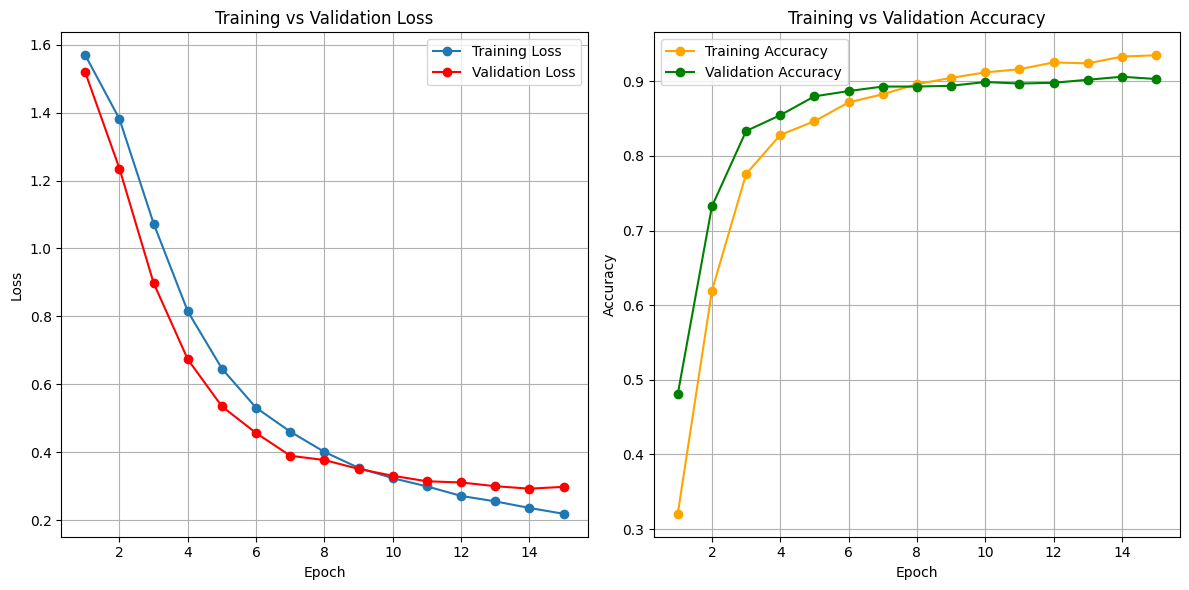

In [16]:
import matplotlib.pyplot as plt

# 손실 및 정확도 그래프
plt.figure(figsize=(12, 6))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker='o', label="Training Loss")
plt.plot(range(1, epochs + 1), val_losses, marker='o', label="Validation Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, marker='o', label="Training Accuracy", color='orange')
plt.plot(range(1, epochs + 1), val_accuracies, marker='o', label="Validation Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### 9. 최적의 모델 성능을 바탕으로 한 F1 score 평가(일반대화 제외)

In [20]:
from sklearn.metrics import f1_score, classification_report
import torch

# 모델 로드
checkpoint_path = "/workspace/best_model_checkpoint_last_left3.pth"  # 최적의 모델이 저장된 경로
model.load_state_dict(torch.load(checkpoint_path)["model_state_dict"])
model.eval()

# 제외할 클래스 정의 (예: '일반 대화' 클래스가 4번이라고 가정)
exclude_class = 4

# 평가 루프
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# 클래스 제외
filtered_preds = [pred for pred, label in zip(all_preds, all_labels) if label != exclude_class]
filtered_labels = [label for label in all_labels if label != exclude_class]

# 제외된 클래스를 반영한 레이블 정의
filtered_class_labels = [0, 1, 2, 3]  # 제외된 '일반 대화' 클래스 번호를 제외한 나머지 클래스
filtered_target_names = ["협박", "갈취", "직장 내 괴롭힘", "기타 괴롭힘"]  # 제외된 클래스 이름 제거

# F1 Score 및 Classification Report 계산
macro_f1 = f1_score(filtered_labels, filtered_preds, average='macro')
weighted_f1 = f1_score(filtered_labels, filtered_preds, average='weighted')

print("Classification Report (Excluding '일반 대화'):")
print(classification_report(filtered_labels, filtered_preds, labels=filtered_class_labels, target_names=filtered_target_names))
print(f"Macro F1 Score (Excluding '일반 대화'): {macro_f1:.4f}")
print(f"Weighted F1 Score (Excluding '일반 대화'): {weighted_f1:.4f}")

/tmp/ipykernel_412317/4136727727.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path)["model_state_dict"])


Classification Report (Excluding '일반 대화'):
              precision    recall  f1-score   support

          협박       0.89      0.90      0.90       199
          갈취       0.85      0.91      0.88       189
    직장 내 괴롭힘       0.93      0.92      0.93       183
      기타 괴롭힘       0.90      0.82      0.86       209

   micro avg       0.89      0.89      0.89       780
   macro avg       0.89      0.89      0.89       780
weighted avg       0.89      0.89      0.89       780

Macro F1 Score (Excluding '일반 대화'): 0.7126
Weighted F1 Score (Excluding '일반 대화'): 0.8898


### F1 score val 평가

In [24]:
# from sklearn.metrics import f1_score, classification_report
# import torch

# # 1. 평가 루프
# model.eval()  # 모델 평가 모드 전환
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for batch in val_loader:  # 기존에 학습 루프에서 사용하던 val_loader 활용
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["label"].to(device)  # 실제 라벨

#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # 예측값
#         all_preds.extend(preds)
#         all_labels.extend(labels.cpu().numpy())  # 실제값

# # 2. F1 Score 및 Classification Report 계산
# macro_f1 = f1_score(all_labels, all_preds, average='macro')
# weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

# print("Classification Report:")
# print(classification_report(all_labels, all_preds, target_names=["협박", "갈취", "직장 내 괴롭힘", "기타 괴롭힘", "일반 대화"]))
# print(f"Macro F1 Score: {macro_f1:.4f}")
# print(f"Weighted F1 Score: {weighted_f1:.4f}")

### 10. 동일하게 전처리 된 Test_data 호출

In [29]:
test_preproc_result2 = pd.read_csv('/workspace/test_data_preproc_last_3.csv')
# 욕설까지 필터링 된 test_data 사용
data = test_preproc_result2
data

,idx,text
0,t_000,아가씨 담배 한 갑 주소 네 4500원입니다 어 네 지갑 어디 갔지 에이 버스에서 ...
1,t_001,우리 팀에서 다른 팀으로 갈 사람 없나? 그럼 영지 씨가 가는 건 어때? 네? 제가...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어 바 와 이 노래 진짜 좋다 그치 요즘 이것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 네가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인이라고도 ...
...,...,...
495,t_495,미나 씨 휴가 결재 올리기 전에 저랑 상의하라고 말한 거 기억해요? 네 합니다. 보...
496,t_496,교수 제 논문에 제 이름이 없나요? 아 무슨 논문 말이야? 지난번 냈던 논문이요. ...
497,t_497,야 너 네 저요? 그래 너 왜요 돈 좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이니...
498,t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제저녁부터 계속 보다...


In [30]:
# 욕설 & 필터링 리스트
bad_words = [
    '씨발', '시발', '씨팔', '개새끼', '새끼', '니미', '병신', '엿', '미친', '꺼져',           #'죽어'
    '닥쳐', '좆', '지랄', '썅', '멍청이', '멍충이', '등신', '바보', '저능아',  # '뒈져'
    '천치', '돌아이', '모지리', '개자식', '미친놈', '미친년', '똘아이', '씹새끼',        #'죽어라',
    '씹년', '걸레', '창녀', '양아치', '호로', '호로새끼', '망나니', '상놈', '하놈',
    '쌍놈', '쌍년', '개잡놈', '쌍판때기', '돌대가리', '골빈놈', '돌머리', '꼴통', '양놈', '돌쇠',
    '돌대가리', '천박한놈', '개돼지', '쓰레기새끼', '개똥', '구제불능', '미친개', '미친돼지',
    '허접', '불쌍한놈', '재수없는놈', '찌질이', '껄렁이', '노답', '개망나니', '하류인간',
    '개망신', '망할놈', '몰상식한놈', '무식한놈', '개같은놈', '얼간이', '어리석은놈',
    '노양심', '양심없는놈', '배은망덕한놈', '정신나간놈', '개같은년', '뒤통수치는놈', '꼬라지',
    '더러운놈', '비열한놈', '천박한년', '가난뱅이', '천박한자식', '못난놈', '구질구질한놈',
    '쓰레기인간', '부정직한놈', '냄새나는놈', '무개념', '몰지각한놈', '놈',
    # 2번 클래스 고위 직급 단어, 회사용어
    '사장', '사장님', '사장한테', '차장', '차장님', '부장', '부장님', '과장', '과장님', '님', '회의', '프레젠테이션',
    # 실제로는 전혀 문제가 되는 말이 아니나, 모델이 어감을 부정적으로 받아들인 단어
    '정신분열증', '정신병', '양극성 장애', '우울증', '공황장애', '불안장애', '조현병', 
    '범죄', '장애인', '신체장애', '지적장애', '시각장애', '청각장애', '언어장애', '발달장애',
]

# 욕설 & 필터링 함수
def remove_bad_words(text):
    for bad_word in bad_words:
        text = text.replace(bad_word, '')
    return text

# 데이터 로드
# train_data = pd.read_csv('train.csv')

# 욕설 제거
data['text'] = data['text'].apply(remove_bad_words)
data

,idx,text
0,t_000,아가씨 담배 한 갑 주소 네 4500원입니다 어 네 지갑 어디 갔지 에이 버스에서 ...
1,t_001,우리 팀에서 다른 팀으로 갈 사람 없나? 그럼 영지 씨가 가는 건 어때? 네? 제가...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어 바 와 이 노래 진짜 좋다 그치 요즘 이것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 네가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인이라고도 ...
...,...,...
495,t_495,미나 씨 휴가 결재 올리기 전에 저랑 상의하라고 말한 거 기억해요? 네 합니다. 보...
496,t_496,교수 제 논문에 제 이름이 없나요? 아 무슨 논문 말이야? 지난번 냈던 논문이요. ...
497,t_497,야 너 네 저요? 그래 너 왜요 돈 좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이니...
498,t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제저녁부터 계속 보다...


In [31]:
# # 결과 저장
# test_data_preproc_last = data
# output_path = "/workspace/test_data_preproc_last_3.csv"  # 결과 저장 경로
# test_data_preproc_last.to_csv(output_path, index=False)
# print(f"Predictions saved to {output_path}")

In [32]:
# 데이터 로드 및 전처리
data['text'] = data['text'].apply(lambda x: x.strip())

class_mapping = {
    "협박 대화": 0,
    "갈취 대화": 1,
    "직장 내 괴롭힘 대화": 2,
    "기타 괴롭힘 대화": 3,
    "일반 대화": 4
}

### 11. Test_data 예측

In [33]:
# 2. 테스트 데이터셋 생성
class TestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=4096):  # KoBigBird는 4096 토큰까지 지원
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
        }

# 3. 모델 및 토크나이저 로드
model_path = "/workspace/best_model_checkpoint_last_left3.pth"
model_name = "monologg/kobigbird-bert-base"

# 토크나이저 및 모델 로드
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

# 체크포인트 로드
checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 4. 데이터로더 생성
test_texts = data['text']  # test_data의 conversation 열 사용
test_dataset = TestDataset(test_texts, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=4)  # KoBigBird는 큰 모델이므로 작은 배치 크기 사용

# 5. 평가 루프
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)


Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at monologg/kobigbird-bert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_412317/2797968840.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they a

In [34]:
# 6. 결과 저장
data['predicted_label'] = all_preds  # 예측 결과를 새로운 열로 추가
output_path = "/workspace/test_data_predict_last_left3_2_notAug_210.csv"  # 결과 저장 경로
data.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")
data

Predictions saved to /workspace/test_data_predict_last_left3_2_notAug_210.csv


,idx,text,predicted_label
0,t_000,아가씨 담배 한 갑 주소 네 4500원입니다 어 네 지갑 어디 갔지 에이 버스에서 ...,1
1,t_001,우리 팀에서 다른 팀으로 갈 사람 없나? 그럼 영지 씨가 가는 건 어때? 네? 제가...,2
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...,2
3,t_003,이거 들어 바 와 이 노래 진짜 좋다 그치 요즘 이것만 들어 진짜 너무 좋다 내가 ...,4
4,t_004,아무튼 앞으로 네가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인이라고도 ...,3
...,...,...,...
495,t_495,미나 씨 휴가 결재 올리기 전에 저랑 상의하라고 말한 거 기억해요? 네 합니다. 보...,2
496,t_496,교수 제 논문에 제 이름이 없나요? 아 무슨 논문 말이야? 지난번 냈던 논문이요. ...,2
497,t_497,야 너 네 저요? 그래 너 왜요 돈 좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이니...,1
498,t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제저녁부터 계속 보다가...,2


In [ ]:
# 2. 테스트 데이터셋 생성
class TestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=4096):  # KoBigBird는 4096 토큰까지 지원
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
        }

# 3. 모델 및 토크나이저 로드
model_path = "/content/drive/MyDrive/Colab_Notebooks_JD_result/Dlthon/model/best_model_checkpoint.pth"
model_name = "monologg/kobigbird-bert-base"

# 토크나이저 및 모델 로드
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

# 체크포인트 로드
checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 4. 데이터로더 생성
test_texts = test_data['text']  # test_data의 conversation 열 사용
test_dataset = TestDataset(test_texts, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=4)  # KoBigBird는 큰 모델이므로 작은 배치 크기 사용

# 5. 평가 루프
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)


Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at monologg/kobigbird-bert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-68-66479fcb1339>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are e

In [ ]:
# 6. 결과 저장
test_data['predicted_label'] = all_preds  # 예측 결과를 새로운 열로 추가
output_path = "/content/drive/MyDrive/Colab_Notebooks_JD_result/Dlthon/model/test_predictions_kobigbird.csv"  # 결과 저장 경로
test_data.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

Predictions saved to /content/drive/MyDrive/Colab_Notebooks_JD_result/Dlthon/model/test_predictions_kobigbird.csv
